In [4]:
import matplotlib.pyplot as plt
import pandas as pd

data_dir = '../../data/'

# Multifidelity modeling of Total Alkalinity

## Low Fidelity Data
Hunt 2021: Gulf of Maine Historical Relationship
TA(micro mol/kg) = SAL(g/kg) * 47.6 + 643

<img src="hunt2021.jpg" alt="drawing" width="300"/>

In [8]:
def lofi(sal):
    return 47.6 * sal + 643

## High Fidelity Data
Shell day and MWRA data

In [16]:
data = pd.read_csv(data_dir + 'concat/MWRA_seagrant_concat_batch.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])
sal_and_ta = data[(data['SAL (PSU)'].notnull()) & (data['TA in (mmol/kgSW)'].notnull())]

### Correlation between low and high fidelity data

Text(0, 0.5, 'TA measured (mmol/kgSW)')

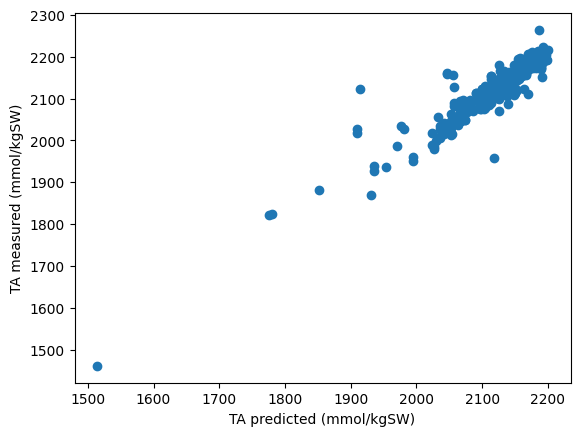

In [18]:
# use the lofi model to predict TA from salinity in a new column
predicted_ta = sal_and_ta['SAL (PSU)'].apply(lofi)

# Plot the lofi model against the hifi data
plt.scatter(predicted_ta, sal_and_ta['TA in (mmol/kgSW)'])
plt.xlabel('TA predicted (mmol/kgSW)')
plt.ylabel('TA measured (mmol/kgSW)')

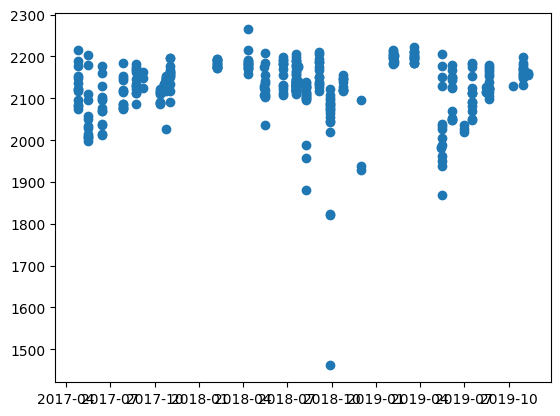

In [19]:
# Plot total alkalinity vs time
plt.scatter(sal_and_ta['PROF_DATE_TIME_LOCAL'], sal_and_ta['TA in (mmol/kgSW)'])